In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [ ]:
from InterpolationNetworks import *
import matplotlib.pyplot as plt ###Should print "cuda" otherwise something is wrong

Final Interpolation Networks Classes
----------------------------- 
File Includes the following Classes
*ControlNN
*QuantumSystem
*InterpolationNetwork (ABSTRACT)
*InterpNN1D
*FrozenNN1D
*InterpNN2D
*FrozenNN2D
----------------------------- 
Current Device: cpu


In [ ]:
"""Setup parameters"""
N = 11
n_steps = 51
dt = 0.2

"""Create list of drive Hamiltonians for system and store on gpu"""
H_drives = np.array([PAULIS["X"],PAULIS["Y"]],dtype='cfloat')
gpu_H_drives = torch.tensor(H_drives).to(device)  ###Always pass these to functions, these are stored on gpu

"""Create a function to compute Rz(theta) and store on gpu"""
m = -1j/2 * PAULIS["Z"]
vals, vecs = np.linalg.eig(m)

vecs_tensor = torch.tensor(vecs).to(device)
vecsT_tensor = torch.tensor(vecs.T.conjugate()).to(device)
vals_tensor = torch.tensor(vals).to(device)

def gpu_excitation(theta):
  return vecs_tensor @ torch.diag(torch.exp(theta * vals_tensor)) @ vecsT_tensor


"""Quantum System Class contrains all the dynamics variables"""
system = QuantumSystem(
    dt=dt, ###Timestep
    n_steps=n_steps, ###Number of steps
    operator=gpu_excitation, ###Target operator
    H_drives=gpu_H_drives ###Drive Hamiltonians
)


In [ ]:
before_pretrained = InterpolationNetwork1D(
    N=N, ###Number of sampled points (for pretraining)
    layers = 1, ###Number of hidden layers (ater first)
    width = 50, ###Network width
    system=system ###Quantum system
)
just_pretrained = InterpolationNetwork1D(
    N=N, ###Number of sampled points (for pretraining)
    layers = 1, ###Number of hidden layers (ater first)
    width = 50, ###Network width
    system=system ###Quantum system
)
pretrained_trained = InterpolationNetwork1D(
    N=N, ###Number of sampled points (for pretraining)
    layers = 1, ###Number of hidden layers (ater first)
    width = 50, ###Network width
    system=system ###Quantum system
)
trained = InterpolationNetwork1D(
    N=N, ###Number of sampled points (for pretraining)
    layers = 1, ###Number of hidden layers (ater first)
    width = 50, ###Network width
    system=system ###Quantum system
)
data = torch.load("/content/drive/MyDrive/FinalXYControlRZ/model_states", map_location=torch.device('cpu'))
before_pretrained.model.load_state_dict(data["before_pretrained"])
just_pretrained.model.load_state_dict(data["just_pretrained"])
pretrained_trained.model.load_state_dict(data["pretrained_trained_model_first"])
trained.model.load_state_dict(data["trained_model_first"])
pretraining_path = "/content/drive/MyDrive/FinalXYControlRZ/FinalXYControlRZ_accels.csv"

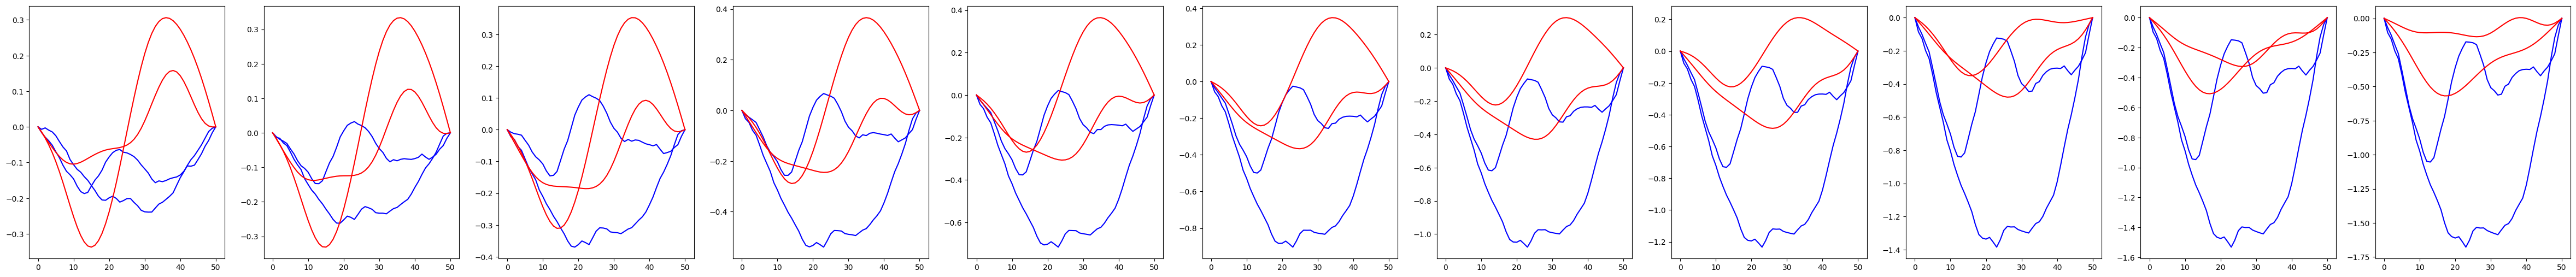

In [ ]:
fig, ax = plt.subplots(1,N,figsize=(60,6))
model_controls1,pretrain_controls1 = before_pretrained.get_comparison_controls(pretraining_path) ###Get the model/pretrain controls
for i in range(N):
    ax[i].plot(model_controls1[i],color='blue')
    ax[i].plot(pretrain_controls1[i],color='red')

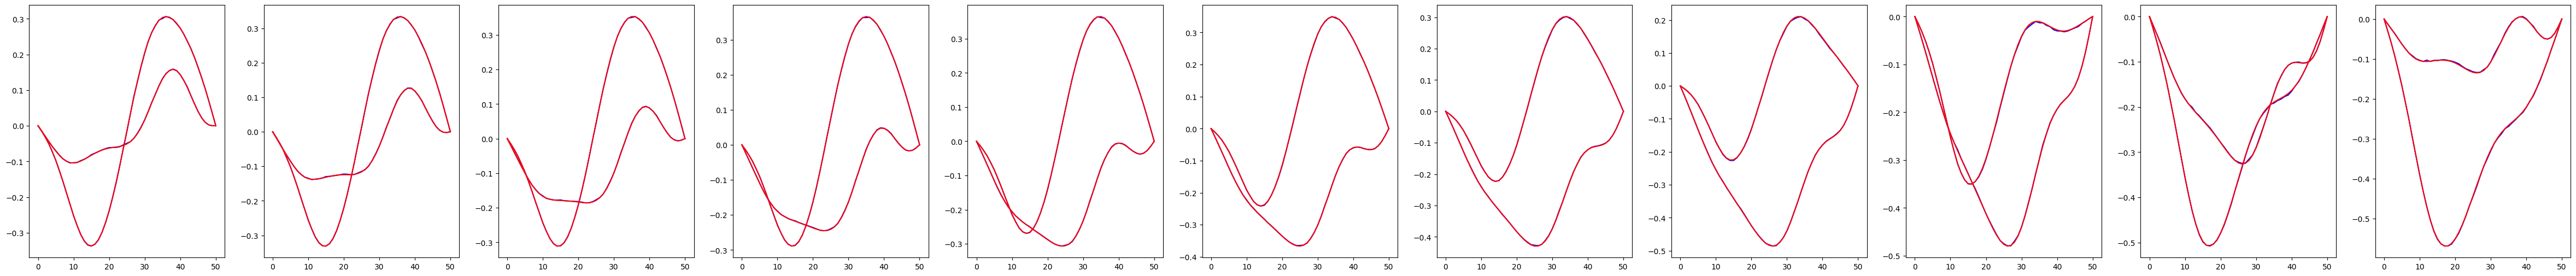

In [ ]:
fig, ax = plt.subplots(1,N,figsize=(60,6))
model_controls2,pretrain_controls2 = just_pretrained.get_comparison_controls(pretraining_path) ###Get the model/pretrain controls
for i in range(N):
    ax[i].plot(model_controls2[i],color='blue')
    ax[i].plot(pretrain_controls2[i],color='red')

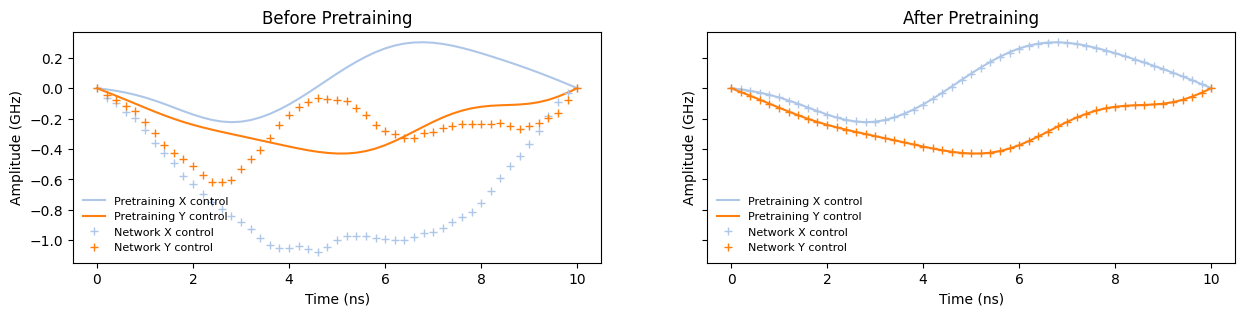

In [ ]:
c1 = plt.get_cmap("tab20")(1)
c2 = plt.get_cmap("tab20")(2)
fig, ax = plt.subplots(1,2,figsize=(15,3),sharey=True)
ax[0].plot(np.linspace(0,dt*(n_steps-1),n_steps),pretrain_controls1[6].T[0],color=c1,label = "Pretraining X control")
ax[0].plot(np.linspace(0,dt*(n_steps-1),n_steps),pretrain_controls1[6].T[1],color=c2,label = "Pretraining Y control")
ax[0].plot(np.linspace(0,dt*(n_steps-1),n_steps),model_controls1[6].T[0],'+',color=c1,label = "Network X control")
ax[0].plot(np.linspace(0,dt*(n_steps-1),n_steps),model_controls1[6].T[1],'+',color=c2,label = "Network Y control")
ax[0].legend(frameon=False,prop={'size': 8})
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Amplitude (GHz)")

ax[0].set_title("Before Pretraining")

ax[1].plot(np.linspace(0,dt*(n_steps-1),n_steps),pretrain_controls2[6].T[0],color=c1,label = "Pretraining X control")
ax[1].plot(np.linspace(0,dt*(n_steps-1),n_steps),pretrain_controls2[6].T[1],color=c2,label = "Pretraining Y control")
ax[1].plot(np.linspace(0,dt*(n_steps-1),n_steps),model_controls2[6].T[0],'+',color=c1,label = "Network X control")
ax[1].plot(np.linspace(0,dt*(n_steps-1),n_steps),model_controls2[6].T[1],'+',color=c2,label = "Network Y control")
ax[1].legend(frameon=False,prop={'size': 8})
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Amplitude (GHz)")
ax[1].set_title("After Pretraining")
plt.savefig("/content/drive/MyDrive/Figure Storage /FinalRZ_Pretraining_Example.pdf",format="pdf",dpi=300) #Save figure
plt.show()


In [ ]:
train_loss = pd.read_csv("/content/drive/MyDrive/FinalXYControlRZ/Train_Loss")
test_loss = pd.read_csv("/content/drive/MyDrive/FinalXYControlRZ/Test_Loss")
epoch_loss = pd.read_csv("/content/drive/MyDrive/FinalXYControlRZ/Epoch_Loss")

In [ ]:
pretraining_epoch_loss = np.array(epoch_loss.iloc[:,1:]).T[1]
training_epoch_loss = np.array(epoch_loss.iloc[:,1:]).T[0]

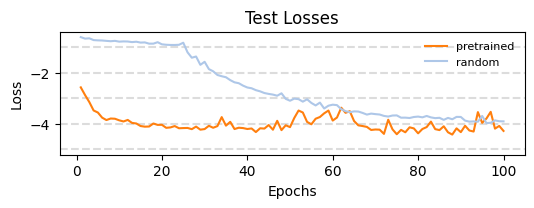

In [ ]:
from matplotlib.pyplot import figure
fig = figure(figsize=(6, 1.6))
for i in range(1,6):
  plt.axhline(y=-i,color='gainsboro',linestyle='--')
plt.legend(frameon=False)
plt.plot(np.array(range(1,101)),np.log10(np.array(pretraining_epoch_loss))[:100],color=c2,label='pretrained')
plt.plot(np.array(range(1,101)),np.log10(np.array(training_epoch_loss))[:100],color=c1,label='random')
plt.legend(frameon=False,fontsize="8")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Test Losses")
plt.savefig("/content/drive/MyDrive/Figure Storage /FinalRzTestLosses.pdf",format="pdf",dpi=300) #Save figure
plt.show()

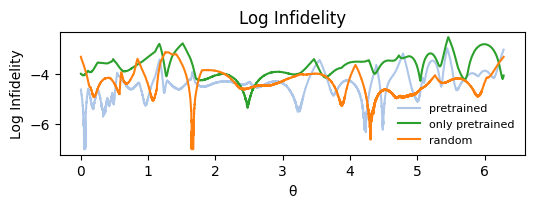

In [ ]:
fig = figure(figsize=(6, 1.6))
theta_list = torch.linspace(0,2*np.pi,5000).to(device)
log_infidelity_vals=pretrained_trained.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals).detach().numpy(),label='pretrained',color=c1)
log_infidelity_vals1=just_pretrained.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals1).detach().numpy(),label='only pretrained',color= plt.get_cmap("tab20")(4))
log_infidelity_vals2=trained.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals2).detach().numpy(),label='random',color=c2)
plt.legend(frameon=False,fontsize="8")
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Log Infidelity")
plt.savefig("/content/drive/MyDrive/Figure Storage /FinalRzInfidData.pdf",format="pdf",dpi=300) #Save figure
plt.show()

In [ ]:
[i for i,v in enumerate(pretraining_epoch_loss) if v<=1e-4][0]

14

In [ ]:
[i for i,v in enumerate(training_epoch_loss) if v<=1e-4][0]

100

In [ ]:
print(f"Mean: {torch.mean(10**log_infidelity_vals)}")
print(f"Std:{torch.std(10**log_infidelity_vals)}")
print(f"Iterations: {[i for i,v in enumerate(pretraining_epoch_loss) if v<=1e-4][0]}")

Mean: 8.101160346996039e-05
Std:0.00012090142990928143
Iterations: 14


In [ ]:
print(f"Mean: {torch.mean(10**log_infidelity_vals2)}")
print(f"Std:{torch.std(10**log_infidelity_vals2)}")
print(f"Iterations: {[i for i,v in enumerate(training_epoch_loss) if v<=1e-4][0]}")

Mean: 9.164486255031079e-05
Std:0.000128736617625691
Iterations: 100
